In [1]:
from astropy.io import fits
import numpy as np
import astropy
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats 
from scipy.optimize import curve_fit

from matplotlib.backends.backend_pdf import PdfPages

In [61]:
file_path = '/home/arya/Desktop/30K_DATA/det0_good_data_30k/fits_file0/202307010_1759_Eu155_on_det0_30000pkts.fits'
hdulist = fits.open(file_path)

In [63]:
data = hdulist[1].data
print(Table(data))

   time    detid pixid pha 
---------- ----- ----- ----
 768359680     0   106 4095
 768375541     0   172 1373
 768393094     1   154 1229
 768412462     0   239 1470
 768435773     1   141 4095
 768439972     1    52 1541
 768441113     1   249  700
 768461582     1    98 1812
 768463311     0   248 1841
 768474868     0   183  536
       ...   ...   ...  ...
2787462447     1     2 1176
2787476204     1    35 1399
2787492062     0   143 1174
2787499839     1    38 1485
2787518967     0   241 1336
2787519100     1   204 1465
2787531981     1   132  888
2787532652     1   132  350
2787533784     0   238  923
2787538347     0   215 1883
Length = 3842560 rows


In [65]:
# Filter data for detid == 
detid = data[data['detid'] == int(input("Detector Id (0/1) = "))]

Detector Id (0/1) =  0


In [67]:
source = input("source name (Am/Ba1/Ba2/Eu1/Eu2) = ")
if source == "Am":
    pha_min = 816  # Minimum PHA value
    pha_max = 1200 # Maximum PHA value
    Energy_value = 59.6
    bin_count = 24
elif source == "Ba1":
    pha_min = 304 
    pha_max = 672-32-32
    Energy_value = 30.85
    bin_count = 20
elif source == "Ba2":
    pha_min = 1136+32+32  
    pha_max = 1632-32
    Energy_value = 81
    bin_count = 29
elif source == "Eu2":
    pha_min = 1632+32  
    pha_max = 2000
    Energy_value = 105.31
    bin_count = 21
else: 
    pha_min = 1200+32+32+32
    pha_max =1760-64-32
    Energy_value = 85.55
    bin_count = 35
print(pha_min,pha_max,Energy_value)

source name (Am/Ba1/Ba2/Eu1/Eu2) =  Eu2


1664 2000 105.31


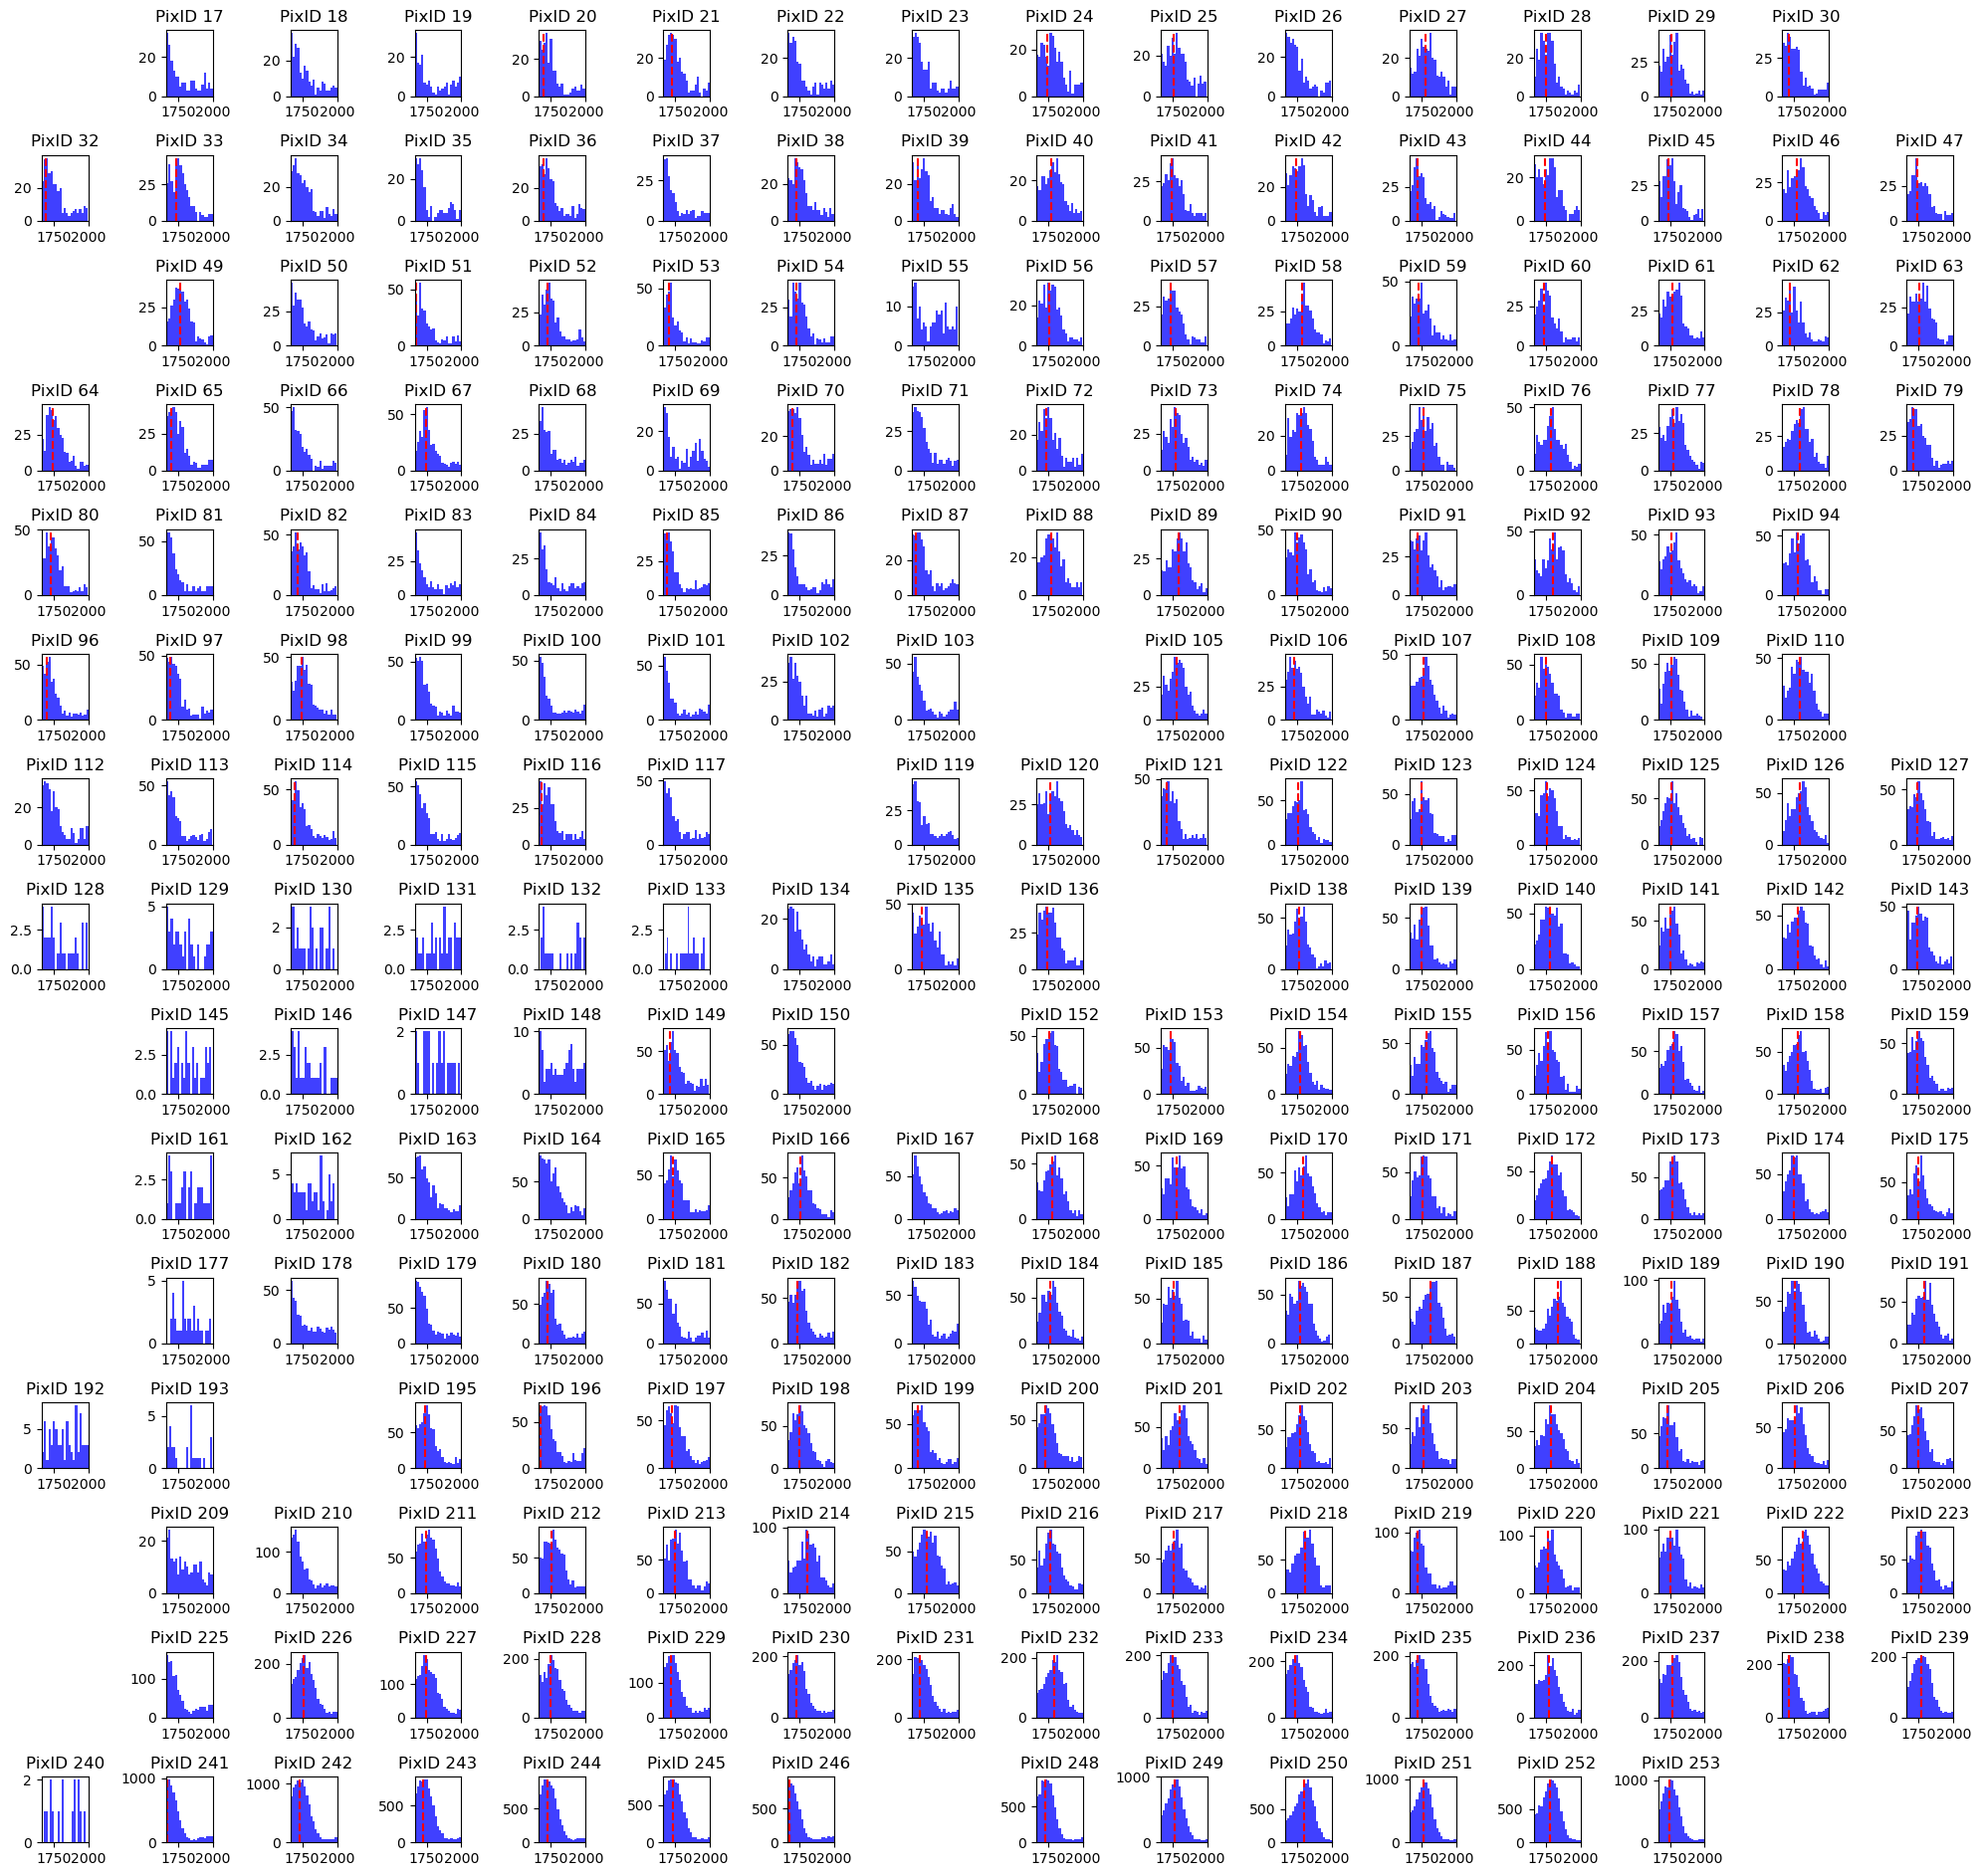

In [69]:
def gauss(x, amp, mean, stdev):
    return amp * np.exp(-(x - mean) ** 2 / (2 * stdev ** 2))

max_count_pha_list = []
max_count_pha_list_OFF = []

for pixid in range(256):
    data_ = detid[detid['pixid'] == pixid]
    data_ = data_['pha']
    filtered_data = data_[(data_ != 4095) & (data_ >= pha_min) & (data_ <= pha_max)]

    if len(filtered_data) > 100:
        N, bins = np.histogram(filtered_data, bins=bin_count)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        p0 = [np.max(N), np.mean(filtered_data), np.std(filtered_data)]
        params = None
        pcov = None
        
        for i in range(10):
            try:
                params, pcov = curve_fit(gauss, bin_centers, N, p0, maxfev=200)
                if np.all((np.abs(p0 - params) / np.sqrt(np.diag(pcov))) > 1):
                    break
                p0 = params
            except RuntimeError:
                continue

        if params is not None:
            max_count_pha_list.append((pixid, params[1], np.sqrt(np.diag(pcov))[1], Energy_value))
        else:
            max_count_pha_list_OFF.append((pixid, None, Energy_value))
    else:
        max_count_pha_list_OFF.append((pixid, None, Energy_value))

# Create 16x16 histogram plot
fig, axes = plt.subplots(16, 16, figsize=(20, 20))
axes = axes.flatten()

for ax, pixid in zip(axes, range(256)):
    data_ = detid[detid['pixid'] == pixid]
    data_ = data_['pha']
    filtered_data = data_[(data_ != 4095) & (data_ >= pha_min) & (data_ <= pha_max)]

    if len(filtered_data) > 10:
        N, bins, _ = ax.hist(filtered_data, bins=bin_count, alpha=0.75, color='blue')
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Check if there's a successful fit
        fit_result = next((item for item in max_count_pha_list if item[0] == pixid), None)
        if fit_result:
            mean_val = fit_result[1]
            ax.axvline(mean_val, color='red', linestyle='--')
        
        ax.set_title(f'PixID {pixid}')
        ax.set_xlim([pha_min, pha_max])
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()
